In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import json


#let's try and make a list of my categories
# 1) read in train annotations JSON
# 2) convert dictionary to a list of classes
# 3) give that to the confusion matrix for clarity

#starting point: df with my cropped instances
#this had to be moved from my WSL to my SSH (with chatgpt's help)
#this will not automatically update if I change it in WSL
#Jan 23: I cannot figure out how to get the updated csv accessible on the SSH
# df = pd.read_csv('/home/Kathryn/code/ct_classifier/data/cropped_instances.csv')
# print(df)

#now let's make an alphabetical list of spp categories
#huzzah, it worked!
# species_list = sorted(df['spp'].unique())

#but I can move it manually
species_list = ['aardvark',
'bird',
'bushbuck',
'civet',
'duiker_spp',
'eland_hartebeest',
'elephant',
'genet',
'hare',
'hippo_buffalo_wildebeest',
'honey_badger',
'impala',
'kudu',
'lion',
'mongoose_spp',
'nyala',
'oribi',
'pangolin',
'pig',
'porcupine',
'primate',
'reedbuck',
'reptile',
'rodent',
'sable_antelope',
'serval',
'unknown_antelope',
'waterbuck']

print(species_list)

['aardvark', 'bird', 'bushbuck', 'civet', 'duiker_spp', 'eland_hartebeest', 'elephant', 'genet', 'hare', 'hippo_buffalo_wildebeest', 'honey_badger', 'impala', 'kudu', 'lion', 'mongoose_spp', 'nyala', 'oribi', 'pangolin', 'pig', 'porcupine', 'primate', 'reedbuck', 'reptile', 'rodent', 'sable_antelope', 'serval', 'unknown_antelope', 'waterbuck']


/mnt/class_data/group4/katie/processed/eccv_18_annotation_files/cis_val_annotations_spp_grouped.json
id_cat_dict : {0: 'aardvark', 1: 'bird', 2: 'bushbuck', 3: 'civet', 4: 'duiker_spp', 5: 'eland_hartebeest', 6: 'elephant', 7: 'genet', 8: 'hare', 9: 'hippo_buffalo_wildebeest', 10: 'honey_badger', 11: 'impala', 12: 'kudu', 13: 'lion', 14: 'mongoose_spp', 15: 'nyala', 16: 'oribi', 17: 'pangolin', 18: 'pig', 19: 'porcupine', 20: 'primate', 21: 'reedbuck', 22: 'reptile', 23: 'rodent', 24: 'sable_antelope', 25: 'serval', 26: 'unknown_antelope', 27: 'waterbuck'}
df.head()
                                         file  pred  true      conf  \
0           buffalo-L07-4406_crop7_animal.JPG    18     9  0.364832   
1           impala-F01-16558_crop1_animal.JPG    11    11  0.941496   
2  mongoose_banded-L07-44075_crop1_animal.JPG     1    14  0.455670   
3       duiker_red-G10-41539_crop1_animal.JPG     2     4  0.254642   
4            genet-B09-14936_crop1_animal.jpg     7     7  0.998882   



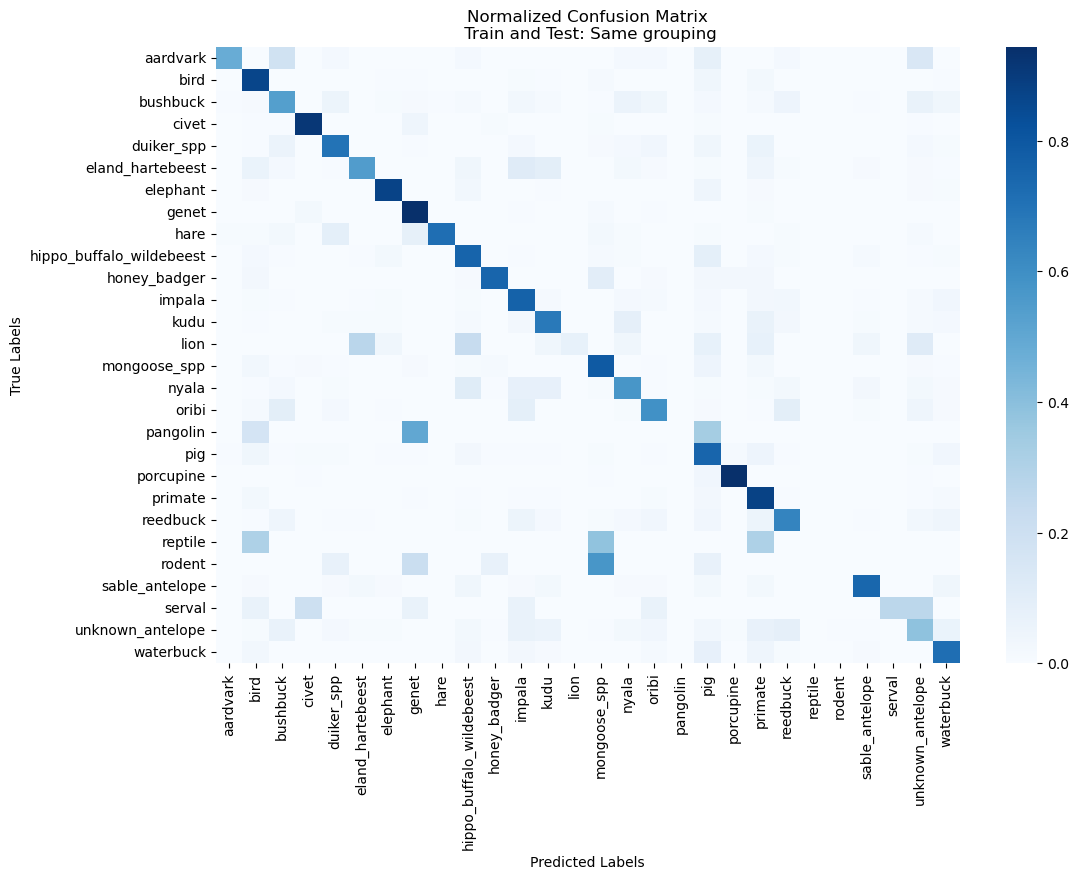

In [2]:
#let's make a confusion matrix from the results csv

root_path = '/home/Kathryn/code/ct_classifier/model_states-2025-01-23_02-01-35'

#read in csv
df = pd.read_csv(f'{root_path}/results.csv')
# print(df)


# lets read in our categories
import yaml

# Reading the YAML file
with open(f'{root_path}/configs_used_for_this_run.yaml', 'r') as file:
    cfg = yaml.safe_load(file)
data_root = cfg['data_root']
val_annotations_filename = cfg['val_annotations_filename']

json_fpath = f"{data_root}/eccv_18_annotation_files/{val_annotations_filename}"

# Now 'config' will be a Python dictionary containing the YAML data
print(json_fpath)

# Load the JSON file
import json
with open(json_fpath, 'r') as file:
    data = json.load(file)
id_cat_dict = {}
for category in data.get('categories'):
    id_cat_dict[category['id']] = category['name']
print(f"id_cat_dict : {id_cat_dict}")
    
# Adding new columns with mapped labels
#this has category names instead of index, with predicted and true values
df['pred_label'] = df['pred'].map(id_cat_dict)
df['true_label'] = df['true'].map(id_cat_dict)


print("df.head()")
print(df.head())


# #Let's work on a confusion matrix - I think we can I think we can
y_true = df['true']
y_pred = df['pred']

# MAH
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_pred, y_true)
print(f"{acc=}")

# # Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(12,8))
#plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=species_list, yticklabels=species_list,ax=ax) 

# Titles and labels
ax.set_title('Normalized Confusion Matrix\n Train and Test: Same grouping')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Show the plot
# plt.show()
# plt.draw()

# print(plt.gcf()) 

plot_fname = "confusion_matrix_groupedgrouped.png"  # Change format as needed (e.g., .pdf)
plot_filepath = os.path.join(root_path, plot_fname)
fig.savefig(plot_filepath) #this function gives you control over how this is saved, ie can save it higher quality
#^can manually set DPI, for example

# Close the figure to free up memory
#plt.close(fig)

# # plt.savefig(f'{root_path}/confusion_matrix.png')  # You can change the file format to .pdf, .jpg, etc.
# plt.close()  

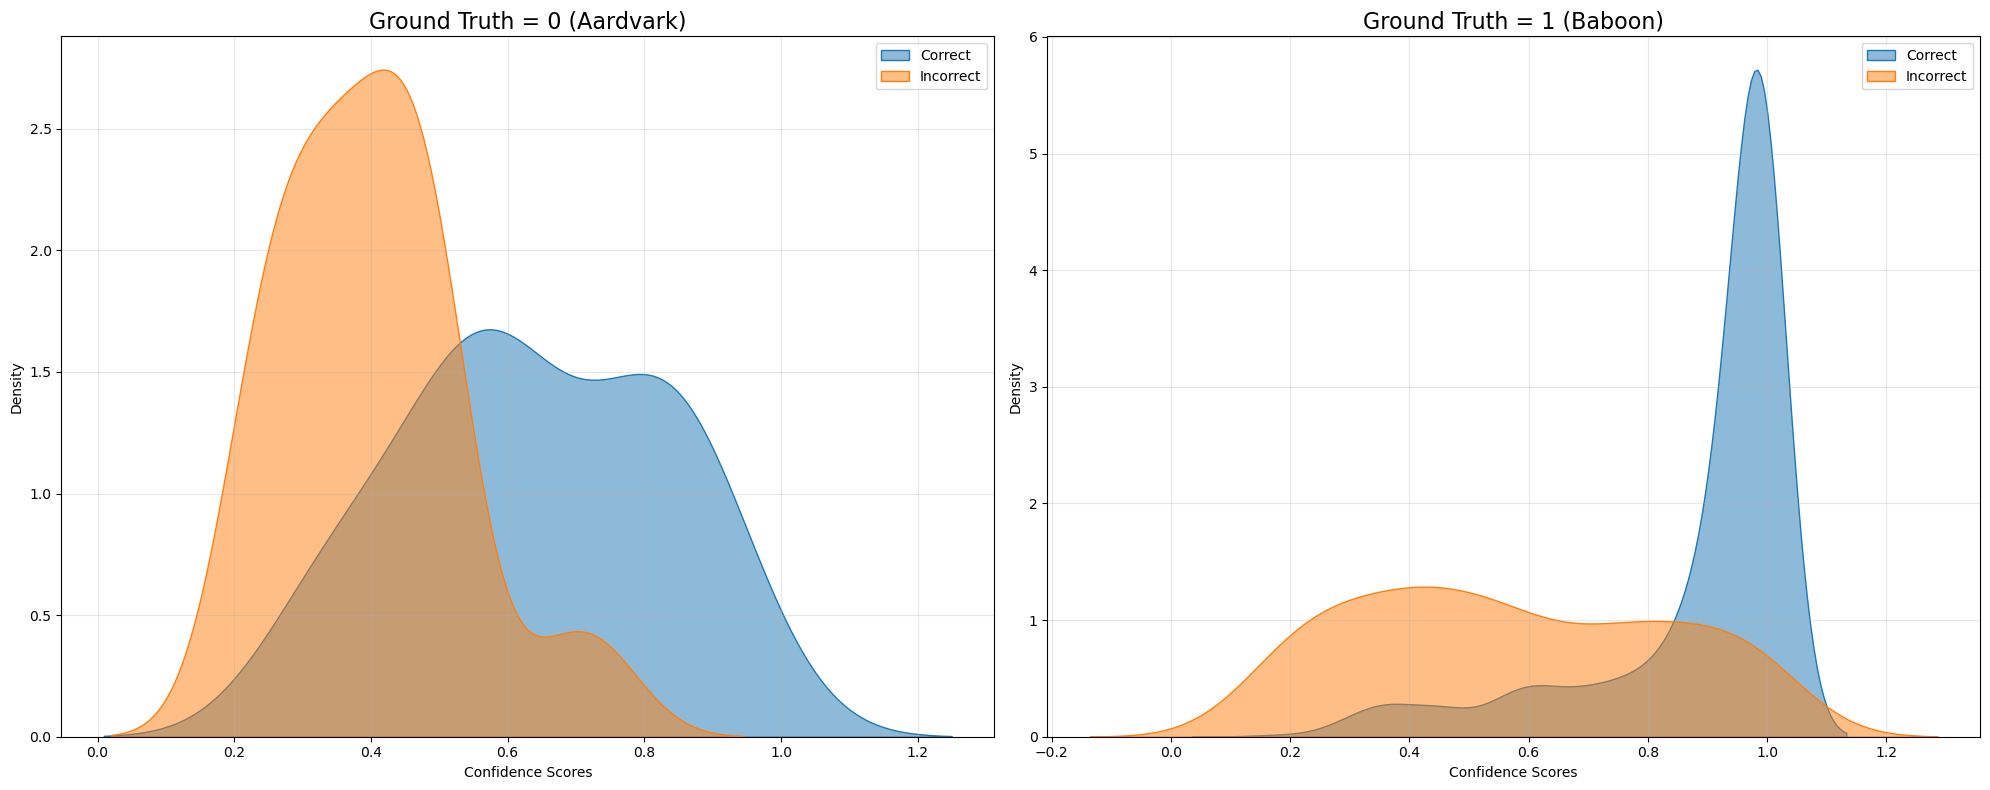

<Figure size 640x480 with 0 Axes>

In [ ]:
#okay I would like to create a histogram, this is code from Talen
#my df is the same setup as his
#there's something about this that Peter recommends changing, he's thinking about it
#this code writes density plots

# Create figure with two panels (1-row, 2-columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Panel 1: ground_truth = 0 [let's try for category 0 - baboons - just to start]
data_gt0 = df[df['true'] == 0]
correct_gt0 = data_gt0[data_gt0['true'] == data_gt0['pred']]['conf']
incorrect_gt0 = data_gt0[data_gt0['true'] != data_gt0['pred']]['conf']
sns.kdeplot(data=correct_gt0, fill=True, alpha=0.5, label='Correct', ax=ax1)
sns.kdeplot(data=incorrect_gt0, fill=True, alpha=0.5, label='Incorrect', ax=ax1)
ax1.set_title('Ground Truth = 0 (Aardvark)', fontsize=16)
ax1.set_xlabel('Confidence Scores')
ax1.set_ylabel('Density')
ax1.grid(True, alpha=0.3)
ax1.legend()

#  Panel 2: ground_truth = 1 [and let's try for category 1 just to start]
data_gt1 = df[df['true'] == 1]
correct_gt1 = data_gt1[data_gt1['true'] == data_gt1['pred']]['conf']
incorrect_gt1 = data_gt1[data_gt1['true'] != data_gt1['pred']]['conf']
sns.kdeplot(data=correct_gt1, fill=True, alpha=0.5, label='Correct', ax=ax2)
sns.kdeplot(data=incorrect_gt1, fill=True, alpha=0.5, label='Incorrect', ax=ax2)
ax2.set_title('Ground Truth = 1 (Baboon)', fontsize=16)
ax2.set_xlabel('Confidence Scores')
ax2.set_ylabel('Density')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
fig.savefig(f'{root_path}/density_hist.png') #this function gives you control over how this is saved, ie can save it higher quality
plt.show()



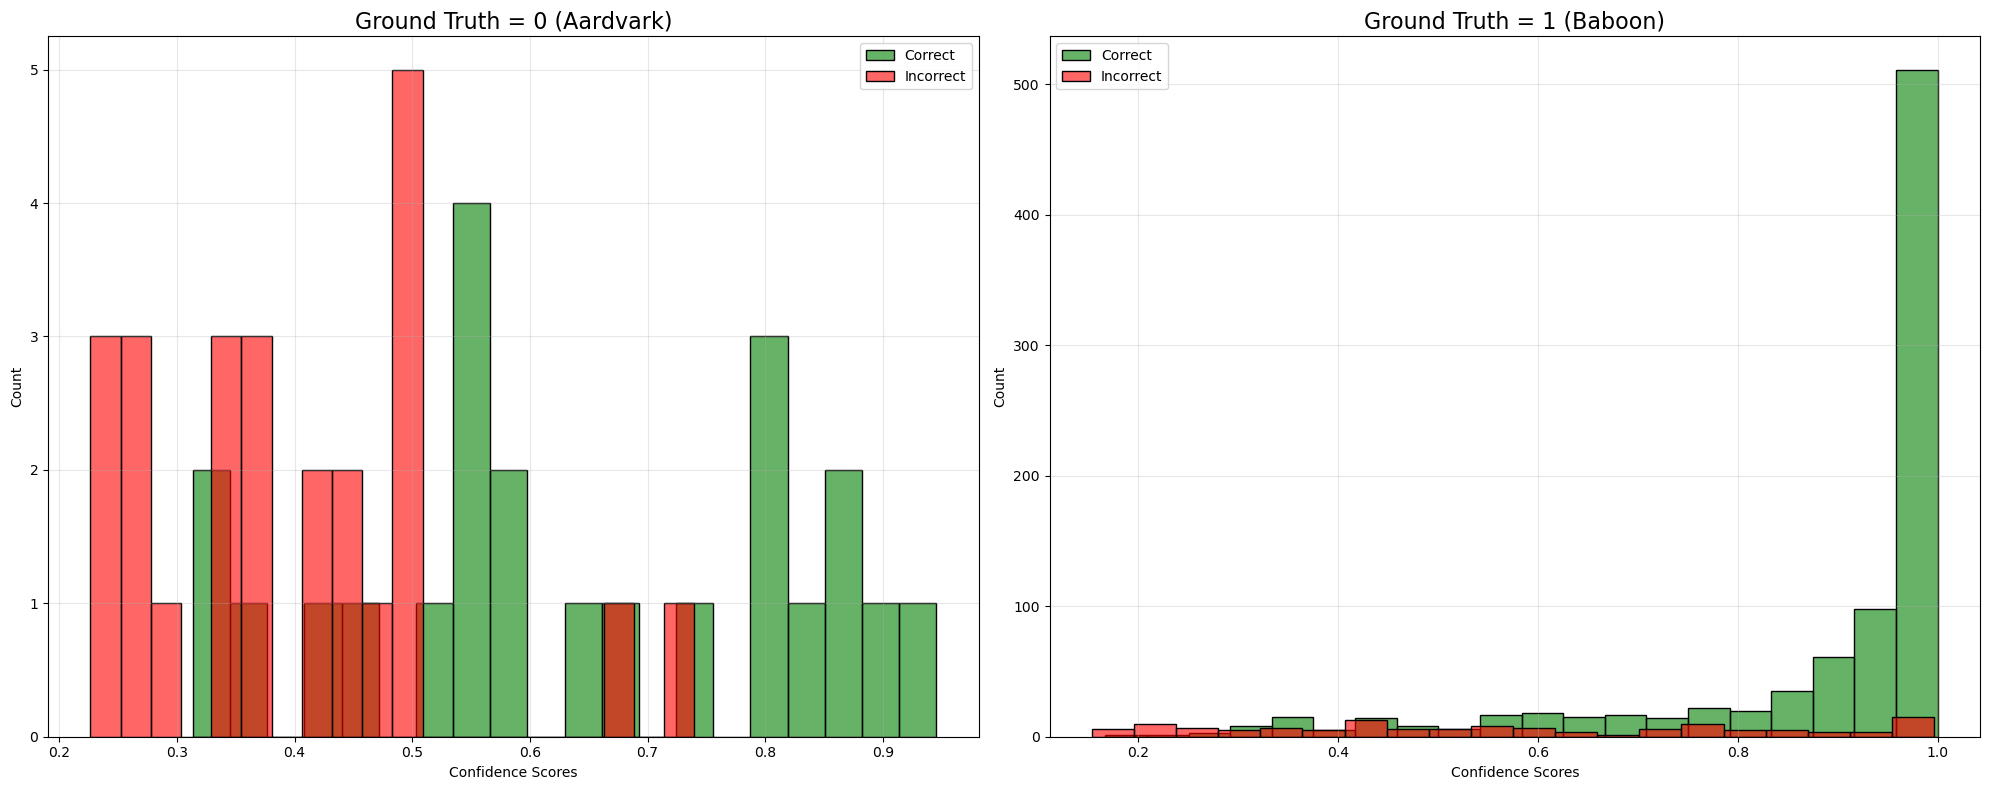

<Figure size 640x480 with 0 Axes>

In [ ]:
#what about absolute value histograms? not densities
# Create figure with two panels (1-row, 2-columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Panel 1: ground_truth = 0 [let's try for category 0 - baboons - just to start]
data_gt0 = df[df['true'] == 0]
correct_gt0 = data_gt0[data_gt0['true'] == data_gt0['pred']]['conf']
incorrect_gt0 = data_gt0[data_gt0['true'] != data_gt0['pred']]['conf']
sns.histplot(data=correct_gt0, bins=20, kde=False, color='g', alpha=0.6, label='Correct', ax=ax1)
sns.histplot(data=incorrect_gt0, bins=20, kde=False, color='r', alpha=0.6, label='Incorrect', ax=ax1)
ax1.set_title('Ground Truth = 0 (Aardvark)', fontsize=16)
ax1.set_xlabel('Confidence Scores')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)
ax1.legend()

#  Panel 2: ground_truth = 1 [and let's try for category 1 just to start]
data_gt1 = df[df['true'] == 1]
correct_gt1 = data_gt1[data_gt1['true'] == data_gt1['pred']]['conf']
incorrect_gt1 = data_gt1[data_gt1['true'] != data_gt1['pred']]['conf']
sns.histplot(data=correct_gt1, bins=20, kde=False, color='g', alpha=0.6, label='Correct', ax=ax2)
sns.histplot(data=incorrect_gt1, bins=20, kde=False, color='r', alpha=0.6, label='Incorrect', ax=ax2)
ax2.set_title('Ground Truth = 1 (Baboon)', fontsize=16)
ax2.set_xlabel('Confidence Scores')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
fig.savefig(f'{root_path}/count_hist.png') #this function gives you control over how this is saved, ie can save it higher quality

plt.show()

# plt.savefig(f'{root_path}/count_hist.png')  # You can change the file format to .pdf, .jpg, etc.

#task: run through all classes with a for loop
#save each individual plot as a file

In [5]:
#what about a figure for every category...let's try

# Directory to save the plots
output_dir = f'{root_path}/confidence_plots'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Number of categories
num_categories = 28

# Set the grid size for the subplots (you can adjust this as needed)
ncols = 5  # Number of columns
nrows = int(np.ceil(num_categories / ncols))  # Number of rows, based on number of categories

# Loop through each category (0 to 50)
for category in species_list:
    # Filter data for the current category

    data_category = df[df['true_label'] == category]
    
    # Get the confidence scores for correct and incorrect predictions
    correct_category = data_category[data_category['true_label'] == data_category['pred_label']]['conf']
    incorrect_category = data_category[data_category['true_label'] != data_category['pred_label']]['conf']
    
    # Create a new figure for each category
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

    # Plot histograms for correct and incorrect predictions
    sns.histplot(data=correct_category, bins=20, kde=False, color='g', alpha=0.6, label='Correct', ax=ax)
    sns.histplot(data=incorrect_category, bins=20, kde=False, color='r', alpha=0.6, label='Incorrect', ax=ax)
    
    ax.set_title(f'Category {category}', fontsize=14)
    ax.set_xlabel('Confidence Scores')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Save the plot to a file
    plot_filename = f"category_{category}_confidence_plot.png"  # Change format as needed (e.g., .pdf)
    plot_filepath = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_filepath)

    # Close the figure to free up memory
    plt.close(fig)

print("Plots saved successfully!")

Plots saved successfully!


In [6]:
#and I'm interested in a classification report
#this is code from Peter, I'm not sure where to break it up
# import csv for reading CSV files

#we ran this code above already

# print(df.head())

# # read in results
# df = pd.read_csv(f'{root_path}/results.csv')

# # Load the JSON file
# with open('/Users/peter/Downloads/cis_val_annotations.json', 'r') as file:
#     data = json.load(file)
# id_cat_dict = {}
# for category in data.get('categories'):
#     id_cat_dict[category['id']] = category['name']
# print(f"id_cat_dict : {id_cat_dict}")
    
# # Adding new columns with mapped labels
# #this has category names instead of index, with predicted and true values
# df['pred_label'] = df['pred'].map(id_cat_dict)
# df['true_label'] = df['true'].map(id_cat_dict)


# print("df.head()")
# print(df.head())

ValueError: `dataset` input should have multiple elements.

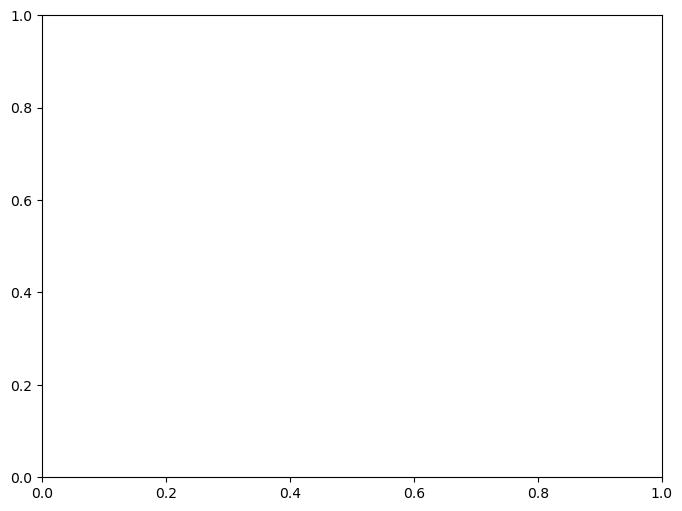

In [7]:
#code chunk 2/3 from Peter
# Calculate logits
df["logits"] = np.log(df["conf"] / (1 - df["conf"]))

# Classify as positive or negative
df["label"] = np.where(df["pred"] == df["true"], "Positive", "Negative")

# choose class
chosen_class = "bushbaby"
filtered_df = df[df["true_label"] == chosen_class]

# Plot histogram for the first class
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x="logits", hue="label", kde=True, multiple="stack", bins=10)
plt.title(f"Logit Distribution for Class {chosen_class}")
plt.xlabel("Logits")
plt.ylabel("Frequency")
plt.show()
plt.savefig(f'{root_path}/logits_hist.png')  # You can change the file format to .pdf, .jpg, etc.

# Plot histogram for the first class
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x="conf", hue="label", kde=True, multiple="stack", bins=10)
plt.title(f"Confidence Distribution for Class {chosen_class}")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()
plt.savefig(f'{root_path}/confidence_hist.png')  # You can change the file format to .pdf, .jpg, etc.

In [5]:
#code chunk 3/3 from Peter for a classification report
from sklearn.metrics import classification_report

# Get unique class IDs in the dataset
unique_labels = sorted(df["true"].unique())

# Generate target names for only the present class IDs
target_names = [id_cat_dict[label] for label in unique_labels]

# Generate classification report
y_true = df["true"]
y_pred = df["pred"]

report = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names)
# print(report)

#export as csv file

#I think I need to save it as a dictionary first
# Get the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
# print(report_dict)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()  # Transpose to make it easier to read

# Save the DataFrame as a CSV file
report_df.to_csv(f'{root_path}/classification_report.csv', index=True)
# report_df.to_csv(f'/mnt/c/', index=True)

# Print the DataFrame (optional, for visual verification)
print(report_df)

                          precision    recall  f1-score      support
aardvark                   0.657143  0.479167  0.554217    48.000000
bird                       0.858937  0.869013  0.863946  1023.000000
bushbuck                   0.586572  0.535484  0.559865   310.000000
civet                      0.894309  0.916667  0.905350   240.000000
duiker_spp                 0.833333  0.699541  0.760599   436.000000
eland_hartebeest           0.869048  0.546816  0.671264   267.000000
elephant                   0.914938  0.873267  0.893617   505.000000
genet                      0.808362  0.943089  0.870544   246.000000
hare                       0.945055  0.716667  0.815166   120.000000
hippo_buffalo_wildebeest   0.797753  0.755319  0.775956   658.000000
honey_badger               0.739130  0.750000  0.744526    68.000000
impala                     0.580902  0.760417  0.658647   288.000000
kudu                       0.579646  0.678756  0.625298   193.000000
lion                       1.00000

/home/Kathryn/miniconda3/envs/cv4ecology/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Kathryn/miniconda3/envs/cv4ecology/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Kathryn/miniconda3/envs/cv4ecology/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [ ]:
# #this is how Talen made df_combined
# import pandas as pd
# import numpy
# # Convert lists to numpy arrays for consistent handling
# # confidence_scores = np.array(confidence_scores)
# argmax_all = np.array(argmax_all)
# gt_all = np.array(gt_all)
# # Create DataFrame with all components
# df_combined = pd.DataFrame({
#     # 'confidence_scores': confidence_scores.tolist(),  # Convert to list for DataFrame
#     'predict_class': argmax_all,
#     'ground_truth': gt_all,
#     'image_id': range(len(img_list)),
#     'filenames':np.array(filenames),
#     'confs':confs_list
# })
# # Set image_id as index
# df_combined.set_index('image_id', inplace=True)
# # Verify structure
# print("DataFrame shape:", df_combined.shape)
# print("\nFirst few rows:")
# print(df_combined.head())

#so this seems like my df too? I think?